# medMorphoBin - First project computer vision
## Discretization of the arterial structure.

- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

repository link: https://github.com/bl33h/medMorphoBin

In [1]:
# librerias
import matplotlib.pyplot as plt
import cv2
import numpy as np

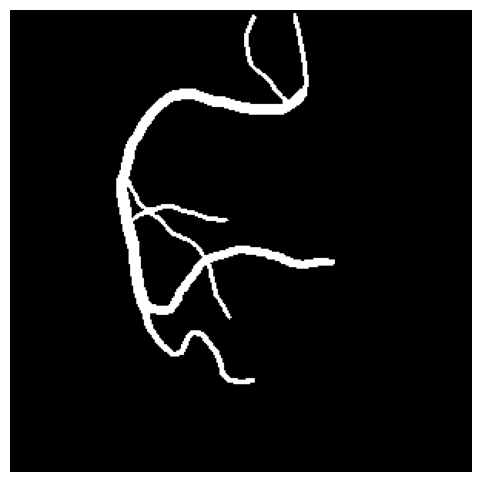

In [3]:
image_path = "img/1_gt.pgm"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Mostrar la imagen
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.show()